<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="" 
               style="width:10px"
           >
           </a>    
       </td>
   </tr>
</table>
<div style="float:right;"><h2>04. Whole population light gbm classifier</h2></div>

 <a id="top"></a> <br>
## Índice
1. [Entradas y Entregable](#1)<br>
    1.1. [Entradas del modelo](#11)<br>
    1.2. [Entregable](#12)<br>
2. [Carga de paquetes y datos](#2)<br>
    2.1. [Librerías y clases](#21)<br>
    2.2. [Lectura de datos](#22)<br>
    2.3. [Eliminación de valores nulos](#23)<br>
    2.4. [Binarización de variable delta_WHP](#24)<br>
    2.5. [Separación en train y test](#25)<br>
3. [Modelo](#3)<br>
    3.1. [Confección pipeline](#31)<br>
    3.2. [Optimización de hiperparámetros](#32)<br>
    3.3. [Entrenamiento del modelo](#33)<br>
    3.4. [Mejores Hiperparámetros](#34)<br>
4. [Evaluación del modelo](#4)<br>
    4.1. [Cálculo de métricas](#41)<br>
    4.2. [Matriz de confusión](#42)<br>
    4.3. [ROC Curve](#43)<br>
    4.4. [Precision-Recall curve](#44)<br>

***
<a id="1"></a> <br>
## 1. Entradas y Entregable

<a id="11"></a>
### 1.1. Entradas

|Tipo|Nombre|Descripción|Ubicación Lab|
|:-------|----------------|---------------------------------------------------|-------------------------------------|
|**csv**| `Dataset participantes.csv` | datos relacionados con los pozos al producirse una interferencia por la estimulación de un pozo hijo |`/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/`|

<a id="12"></a>
### 1.2. Entregable

**Archivo csv con las estimaciones de delta_WHP**

***
<a id="2"></a> <br>
## 2. Carga de paquetes y datos

<a id="21"></a>
### 2.1. Librerías y clases

In [ ]:
# Esta clase permite dropear columnas de un DataFrame dentro de un pipeline

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

In [ ]:
!pip install feature_engine
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.2 MB/s 
     |████████████████████████████████| 81 kB 8.9 MB/s 
     |████████████████████████████████| 209 kB 52.9 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 147 kB 50.7 MB/s 
     |████████████████████████████████| 112 kB 42.5 MB/s 
     |████████████████████████████████| 50 kB 5.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=7e20d2d1cea2b82e74f147b71f424f37378deed13000cc55513b5397fa9637fd
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import recall_score, confusion_matrix, roc_curve, average_precision_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import lightgbm as lgb

import chardet

import warnings
warnings.filterwarnings("ignore")

from feature_engine.selection import DropFeatures
import pickle
from sklearn.model_selection import cross_val_score

<a id="22"></a> <br>
### 2.2. Lectura de datos

In [ ]:
# Detección automática de la codificación de los caracteres
with open("/content/Dataset participantes (corregido).csv", 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large

# Lectura del csv
df = pd.read_csv("/content/Dataset participantes (corregido).csv",encoding = enc['encoding'], index_col=0)

df.sample(5)

,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
ID_FILA,,,,,,,,,,,,,,,,
5299,Pozo 377-Pozo 210-11,Campo F,OIL,PAD-72,Pozo 377,11,Pozo 210,1312.446892,1312.434662,-5.665914,61.312407,1.0,NO,42.8,0.0,Abierto
24491,Pozo 554-Pozo 404-29,Campo E,OIL,PAD-85,Pozo 554,29,Pozo 404,374.747102,371.980821,-45.449521,84.891533,0.0,NO,362.1,0.0,Cerrado
19067,Pozo 129-Pozo 92-23,Campo C,GAS,PAD-25,Pozo 129,23,Pozo 92,1247.837275,1247.825640,5.388569,207.265043,0.0,NO,66.9,0.0,Cerrado
24997,Pozo 80-Pozo 77-30,Campo D,OIL,PAD-47,Pozo 80,30,Pozo 77,524.988412,524.433136,-24.139556,323.672145,0.0,NO,404.5,0.0,Cerrado
22021,Pozo 32-Pozo 24-19,Campo B,OIL,PAD-6,Pozo 32,19,Pozo 24,1174.166441,1172.790590,56.824845,289.627458,0.0,NO,216.3,0.0,Cerrado


In [ ]:
# Se cambia el tipo de datos de variables categóricas nominales de object a category
df = df.astype({"CAMPO": "category", "FLUIDO": "category", "PAD_HIJO": "category", "HIJO": "category",
                "ETAPA_HIJO": "category", "PADRE": "category", "LINEAMIENTO": "category", "ESTADO": "category"})
df.dtypes

ID_EVENTO        object
CAMPO          category
FLUIDO         category
PAD_HIJO       category
HIJO           category
ETAPA_HIJO     category
PADRE          category
D3D             float64
D2D             float64
DZ              float64
AZ              float64
#_BARRERAS      float64
LINEAMIENTO    category
WHP_i           float64
delta_WHP       float64
ESTADO         category
dtype: object

<a id="23"></a> <br>
### 2.3. Eliminación de valores nulos
**Dado que el modelo a desarrollar en el presente notebook será tomado como baseline, se eliminan los valores nulos para mayor practicidad**

In [ ]:
print("Cantidad de instancias totales =", df.shape[0])
# Eliminación de todos los valores nulos de dataset
df.dropna(inplace=True)
print("Cantidad de instancias sin valores nulos =", df.shape[0])

Cantidad de instancias totales = 26178
Cantidad de instancias sin valores nulos = 26178


<a id="24"></a> <br>
### 2.4. Binarización de variable delta_WHP

In [ ]:
# Se crea una nueva variable en donde se asigna valor 0 cuando delta_WHP = 0 y valor 1 cuando delta_WHP != 0
df["delta_WHP_binarized"] = df["delta_WHP"].apply(lambda val: 1 if val != 0 else 0)

<a id="25"></a> <br>
### 2.5. Clasificador

In [ ]:
# Cargo modelo preentrenado 

c_model = pickle.load(open('/content/classifier_model.pickle', 'rb'))

In [ ]:
df.columns

Index(['ID_EVENTO', 'CAMPO', 'FLUIDO', 'PAD_HIJO', 'HIJO', 'ETAPA_HIJO',
       'PADRE', 'D3D', 'D2D', 'DZ', 'AZ', '#_BARRERAS', 'LINEAMIENTO', 'WHP_i',
       'delta_WHP', 'ESTADO', 'delta_WHP_binarized'],
      dtype='object')

In [ ]:
scores = c_model.predict_proba(df.drop('delta_WHP', axis=1))[:,1]
c_model.predict_proba(df.drop('delta_WHP'))[:,1]


In [ ]:
# Función objetivo de optuna

def objective_pipe(trial):

  # Selección de universo de entrenamiento de regresor a partir del umbral del modelo de clasificación


  c_threshold = trial.suggest_float("c_threshold", 0, 1)

  df_ones_train = df[scores >= c_threshold].drop('delta_WHP', axis=1)
  df_ones_target = df[scores >= c_threshold].delta_WHP

  df_zeros_train = df[scores < c_threshold].drop('delta_WHP', axis=1)
  df_zeros_target = df[scores < c_threshold].delta_WHP

  params = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)

    }


  # Pipeline modelo
  light_gbm_class = lgb.LGBMRegressor(**params)
  
  # Instanciado de pipeline
  pipe = Pipeline([ ("ColumnDropper", DropFeatures(["ID_EVENTO"])),
                    
                    ("column_transformer",ColumnTransformer([
                                          ("standard_scaler", StandardScaler(), 
                      ["D3D", "D2D", "DZ", "AZ", "WHP_i", "#_BARRERAS"])])),
                                  
                                  ("light_gbm_class", light_gbm_class)])
  
   
   
  # Cross validation
  kfold = StratifiedKFold(n_splits=3, random_state=1, shuffle=True)    

  # RMSEs calculations
  
  mean_rmse_ones = cross_val_score(pipe, df_ones_train, df_ones_target, cv = kfold, scoring= 'rmse').mean()
  mean_rmse_zeros = cross_val_score(pipe, df_zeros_train, df_zeros_target, cv = kfold, scoring= 'rmse').mean()

  # Metric return

  mean_rmse = (mean_rmse_ones + mean_rmse_zeros) / 2

  return mean_rmse


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

<a id="25"></a> <br>
### 2.6. Regresor y reglas duras

<a id="25"></a> <br>
### 2.5. Separación en train y test

In [ ]:
# Selección de variable target
y = df.delta_WHP_binarized
# Selección de features
X = df.drop(["delta_WHP_binarized"], axis = 1)

# Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,  stratify= y, random_state = 161)

# Verificación de distribución de variable targuet en train y test
print("Instancias de train \n", X_train.shape[0])
print("Instancias de test \n", X_test.shape[0])

Instancias de train 
 19633
Instancias de test 
 6545


***
<a id="#3"></a> <br>
## 3. Modelo

<a id="31"></a> <br>
### 3.1. Confección pipeline

In [ ]:
# Instanciado de estimador
light_gbm_class = lgb.LGBMClassifier(random_state = 45)

# Instanciado de pipeline
pipe = Pipeline([ ("ColumnDropper", ColumnDropper(["ID_EVENTO", "delta_WHP"])),
                  
                  ("column_transformer",ColumnTransformer([
                                        ("standard_scaler", StandardScaler(), 
                    ["D3D", "D2D", "DZ", "AZ", "WHP_i", "#_BARRERAS"])])),
                                 
                                 ("light_gbm_class", light_gbm_class)])

<a id="32"></a> <br>
### 3.2. Optimización de hiperparámetros

In [ ]:
# Optimización de hiperparámetros del modelo con grid search y cross validation

kfolds=StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

params_grid = { 
                "light_gbm_class__max_depth" : [50, 100, 200],
                "light_gbm_class__learning_rate": [0.005, 0.01, 0.1, 0.5, 1],
                "light_gbm_class__n_estimators" : [100, 300, 500, 800]
               }

model = GridSearchCV (pipe, params_grid,cv=kfolds, n_jobs = -1, scoring = "recall", refit = True)

<a id="33"></a> <br>
### 3.3. Entrenamiento del modelo

In [ ]:
# Seteado de parámetros de entrenamiento
fit_params={"light_gbm_class__categorical_feature": "auto" }

# Entrenamiento del modelo
model.fit(X_train,y_train, **fit_params)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('ColumnDropper',
                                        ColumnDropper(columns=['ID_EVENTO',
                                                               'delta_WHP'])),
                                       ('column_transformer',
                                        ColumnTransformer(transformers=[('standard_scaler',
                                                                         StandardScaler(),
                                                                         ['D3D',
                                                                          'D2D',
                                                                          'DZ',
                                                                          'AZ',
                                                                          'WHP_i',
                                                              

<a id="34"></a> <br>
### 3.4. Mejores hiperparámetros

In [ ]:
# Mejores hiperparámetros obtenidos por cross validation y grid search

model.best_params_

{'light_gbm_class__learning_rate': 0.1,
 'light_gbm_class__max_depth': 50,
 'light_gbm_class__n_estimators': 500}

***
<a id="#4"></a> <br>
## 4. Evaluación del modelo

<a id="41"></a> <br>
### 4.1. Cálculo de métricas

In [ ]:
# recall_score
recall_train = recall_score(y_train, model.predict(X_train))
print("Recall train = ", recall_train)
recall_test = recall_score(y_test, model.predict(X_test))
print("Recall test = ", recall_test)

Recall train =  0.9765358361774744
Recall test =  0.6798975672215108


<a id="42"></a> <br>
### 4.2. Matriz de confusión

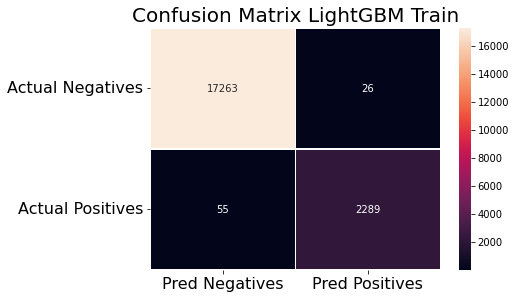

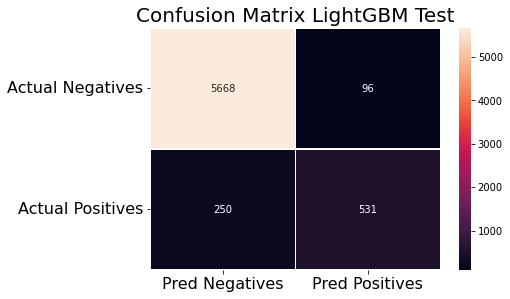

In [ ]:
# Matriz de confusión para modelo
conf_matrix = confusion_matrix(y_train,  model.predict(X_train))
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Train", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

conf_matrix = confusion_matrix(y_test,  model.predict(X_test))
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Test", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

<a id="43"></a> <br>
### 4.3. ROC Curve

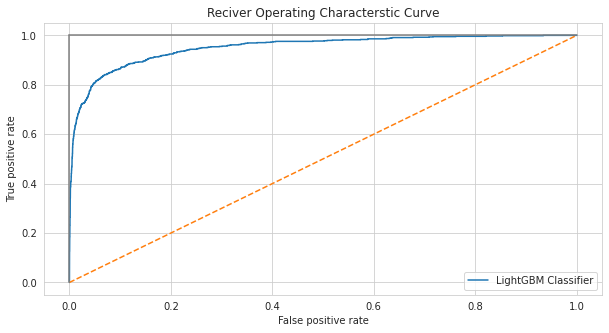

In [ ]:
# Obtencion de predicciones para graficar curva ROC
probsdmodel = model.predict_proba(X_test)
predsdmodel = probsdmodel[:,1]

lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(y_test,predsdmodel)


# Grafico curva ROC
sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='LightGBM Classifier')

plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

<a id="44"></a> <br>
### 4.4. Precision-Recall Curve

In [ ]:
sample_weight en el fit, le paso weights del dato del entrenamiento

0.8283907140080655


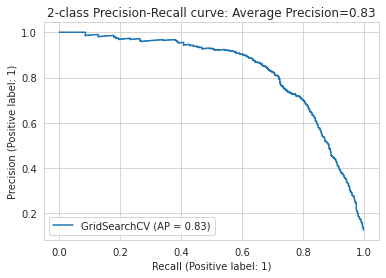

In [ ]:
# Curva Precision-Recall
average_precision = average_precision_score(y_test, predsdmodel)

print(average_precision)

disp = plot_precision_recall_curve(model, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'Average Precision={0:0.2f}'.format(average_precision));